# Data driven business analytics - Homework 2

## Problem 3. Causal discovery
In this notebook you will have to implement a simplified version of PC algorithm for causal discovery. To do this, you need to implement the following methods:
  - `get_partial_correlation` - computes the partial correlation between two random variables X and Y given a third variable Z
  - `identify_skeleton` - computes the skeleton of the causal graph $G$ from the correlation matrix computed over the random variables from the graph
  -  `identify_v_structures` - finds v-structures in the graph $G$ from a skeleton and from the records of conditional dependences between all pairs of variables
  - `Meek_rule1` - applies the first Meek orientation rule to orient more edges in the learned graph (see below)
  - `Meek_rule2` - applies the second Meek orientation rule to orient more edges in the learned graph (see below)
  - `Meek_rule3` - applies the third Meek orientation rule to orient more edges in the learned graph (see below)
  - `PC` - aggregates all previous methods and runs the (simplified) PC algorithm for causal discovery

Let us start with some useful packages:

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

### Identifying the skeleton via conditional independence tests

The core tools for the PC algorithm are conditional independence tests. In general, the task of deciding whether the random variables $X$ and $Y$ are conditionally independent given a set of random variables $\mathbf{Z}$, from a finite number of samples, is challenging.

In this notebook we will consider a simplified version of the PC algorithm, where criterions for conditional independence are simplified as follows.

  1. Only tests for $X \perp Y$ (unconditioned joint independence) or $X \perp Y \mid Z$ (joint independence conditioned to only *one* variable) will be considered.
  
  2. The statistical criterion for declaring that $X$ is independent from $Y$ will be $|cor(X, Y)| < \alpha$, where $cor(X, Y)$ is the correlation, and the significance level $\alpha$ can be taken to be $0.05$.
  
  3. The statistical criterion for declaring that $X$ is independent from $Y$ given $Z$ will be $|cor(X, Y \mid Z)| < \alpha$, where $cor(X, Y)$ is the partial correlation, and the significance level $\alpha$ can be taken to be $0.05$. For more details on how to compute partial correlation, have a look at this [wiki link](https://en.wikipedia.org/wiki/Partial_correlation), where the partial correlation is denoted by $\rho_{XY\cdot Z}$.

Now, the first function we ask you to implement is `get_partial_correlation`, which computes this partial correlation $cor(X, Y \mid Z)$ from the correlation matrix.

In [22]:
def get_partial_correlation(x_id, y_id, z_id, corr_matrix):
    """
    Parameters:
        x_id - id of random variable X in correlation matrix corr_matrix (int)
        y_id - id of random variable Y in correlation matrix corr_matrix (int)
        z_id - id of random variable Z in correlation matrix corr_matrix (int)
        corr_matrix - correlation matrix for the features (2-dimensional np.array)
    Return:
        res - partial correlation between random variables X and Y given controlling variable Z (float)
    """
    ############################################################################
    # TODO: Compute partial correlation between random variables X and Y       #
    #    conditional to variable Z.                                            #
    ############################################################################
    
    res = corr_matrix[np.ix_([x_id, y_id, z_id], [x_id, y_id, z_id])]
    det = np.linalg.det(res)

    if np.linalg.det(res)==0:
        #print("singular using pinv")
        res = np.linalg.pinv(res)
    else:
        res = np.linalg.inv(res)

    res = -res[0, 1] / np.sqrt(res[0, 0] * res[1, 1])

    return res
    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################

    return res


The first step of the PC algorithm is to find the skeleton of the causal graph $G$. For this, you need to implement the function `identify_skeleton`, which takes as input:
- `adj_matrix` - adjacency matrix that in the begininning represent the fully connected graph;
- `corr_matrix` - correlation matrix between all variables in graph $G$;
- `alpha` - significance level.

The function should iterate through all pairs of the variables in graph $G$, i.e. $X_i, X_j$ and check whether $X_i$ is independent from $X_j$ or whether there exists a variable $X_k\neq X_i, X_j$ such that $X_i \perp  X_j \mid X_k$. Then, if $X_i \perp X_j \mid X_k$ or $X_i \perp X_j$ then there is no edge between $X_i$ and $X_j$ in the graph $G$.

Additionally, for any pair of variables $(X_i, X_j)$ you will need to store all variables $X_k$ into the dictionary `dependencies` such that:
  - $X_k\neq X_i, X_j$;
  - $X_i \not\perp X_j \mid X_k$.

As an example of what `dependencies` should contain, if $X_i, X_j, X_{k_1}, X_{k_2}, X_{k_3}$ are such that $i<j$ and
  - $X_{k_1}\neq X_i, X_j$ and $X_{k_2}\neq X_i, X_j$, $X_{k_3}\neq X_i, X_j$
  - $X_i \not\perp X_j \mid X_{k_1}$ and $X_i \not\perp X_j \mid X_{k_2}$, and $X_i \perp X_j \mid X_{k_3}$.
  
Then dictionary `dependencies` will contain $\{(i, j): [k_1, k_2] \}$, where tuple $(i, j)$ is a key and $[k_1, k_2]$ is the list of all indices $k$ that was mentioned before. 

Note that the keys of dictionary `dependencies` are the ordered pair of integers $(i, j)$, i.e. $i < j$

In [3]:
def identify_skeleton(adj_matrix, corr_matrix, alpha=0.05):
    """
    Parameters:
        adj_matrix - adjacency matrix (2-dimensional np.array) 
        corr_matrix - correlation matrix of the random variables in DAG (2-dimensional np.array)
        alpha - significance level (float)
    Return:
        adj_matrix - updated adjacency matrix (2-dimenstional np.array)
        dependencies - a dictionary that for each pair of random variables (X, Y) stores all 
                variables Z that make X, Y conditionally dependent.
    """
    ############################################################################
    # TODO: Find the skeleton structure and update adj_matrix accordingly.     #
    ############################################################################
    # Replace "..." with your code
    dependencies = dict()
    N = adj_matrix.shape[0]
    id_to_name = {key: name for key, name in enumerate(["A", "B", "C", "D", "E"])}
    
    for i in range(N):
        for j in [x for x in range(N) if x != i]:
            test = (abs(corr_matrix[i,j]) < alpha)
            #print(i,j,test)
            for k in [x for x in range(N) if x != i and x != j]:
                test += (abs(get_partial_correlation(i,j,k,corr_matrix)) < alpha)
                #print("("+id_to_name[i]+","+id_to_name[j]+","+id_to_name[k]+") = "+str((abs(get_partial_correlation(i,j,k,corr_matrix)) < alpha)))
            if test >= 1:
                adj_matrix[i,j] = 0
                
    for i in range(N-1):
        for j in range(i+1,N): 
            if abs(corr_matrix[i,j]) < alpha:
                temp = []
                for k in [x for x in range(N) if x != i and x != j]:
                    #print(i,j,k,abs(get_partial_correlation(i,j,k,corr_matrix)))
                    if abs(get_partial_correlation(i,j,k,corr_matrix)) > alpha:
                        temp.append(k)
                if temp:
                    dependencies[(i,j)] = temp        
                        
    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    
    return adj_matrix, dependencies

### Finding the v-structures
In a second step, we need to implement a function which finds all *v-structures* in the skeleton of the graph $G$.

*Hint:* You don't need to perform any other conditional independence tests. Dictionary `dependencies` which was defined above is all you need.

In [4]:
def identify_v_structures(adj_matrix, dependencies):
    """
    Parameters:
        adj_matrix - adjacency matrix (2-dimensional np.array) 
        dependencies - a dictionary that for each pair of random variables (X, Y) stores all 
                variables Z that make X, Y conditionally dependent.
    Return:
        adj_matrix - updated adjacency matrix (2-dimenstional np.array)
    """
    ############################################################################
    # TODO: Find all v-structures in the graph and orient the edges in         #
    #   adjacency matrix accordingly.                                          #
    ############################################################################
    # Replace "..." with your code
    for i,j in dependencies:
        val = dependencies[i,j]
        #print(i,j,val)
        adj_matrix[val,i] = 0
        adj_matrix[val,j] = 0

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    
    return adj_matrix

### Meek orientation rules
In the lectures, we saw that after obtaining the skeleton and the v-structures, some more edges could be oriented.
The rules that enable new edges to get oriented are called Meek rules and are presented hereafter.

**First Rule**\
Assume there are three random variables $A$, $B$, $C$ such that
- an edge between $A$ and $B$ is oriented from $A$ to $B$,
- an edge between $B$ and $C$ is not oriented,
- there is no edge from $A$ to $C$,

then the edge between $B$ and $C$ can be oriented from $B$ to $C$.

The following picture gives an illustration of this First Rule.\
![](Rule1.png)

Function `Meek_rule1` takes an object (graph) of the class `nx.DiGraph` as an input, and for any triple of variables from the graph, checks whether First Rule can be applied; if so, it orients the edges accordingly.

*Hint:* the following methods from the `networkx` package can be useful:
  - `to_numpy_array`
  - `predecessors`
  - `successors`
  - `remove_edge`
  - `neighbors`
  
Please look into the `networkx` package documentation for more details.

In [5]:
def Meek_rule1(graph):
    """
    Parameters:
        graph - causal graph (instance of nx.DiGraph)
    Return:
        graph - updated causal graph (instance of nx.DiGraph)
        deleted_edges - list of tuples that represent the direct edges that were deleted, such as [(0, 1), (2, 3)]
    """
    ############################################################################
    # TODO: Apply the first Meek orientation rule to the graph and update the  #
    #   edges accordingly.                                                     #
    ############################################################################
    deleted_edges = []
    
    for x in graph.nodes():
        successors = list(graph.successors(x))
        predecessors = list(graph.predecessors(x))
        #print(x,successors,predecessors)
        
        if successors and predecessors and not successors == predecessors:
            for successor in successors:
                for predecessor in [k for k in predecessors if k not in successors]:
                    if graph.has_edge(predecessor, x) and not graph.has_edge(x, predecessor):
                        if graph.has_edge(successor, x) and graph.has_edge(x, successor):
                            if ( not graph.has_edge(predecessor, successor) ) and ( not graph.has_edge(successor, predecessor) ):
                                graph.remove_edge(successor,x)
                                deleted_edges.append((successor, x))
                                    
    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    
    return graph, deleted_edges

**Second Rule**\
Assume there are three random variables $A$, $B$, $C$ such that
- an edge between $A$ and $B$ is oriented from $A$ to $B$,
- an edge between $B$ and $C$ is oriented from $B$ to $C$,
- an edge between $A$ and $C$ is not oriented,

then the edge between $A$ and $C$ can be oriented from $A$ to $C$. 

The following picture gives an illustration of this Second Rule.\
![](Rule2.png) 

Function `Meek_rule2` takes an object (graph) of the class `nx.DiGraph` as an input, and for any triple of variables from the graph, checks whether Second Rule can be applied; if so, it orients the edges accordingly.

In [6]:
def Meek_rule2(graph):
    """
    Parameters:
        graph - causal graph (instance of nx.DiGraph)
    Return:
        graph - updated causal graph (instance of nx.DiGraph)
        deleted_edges - list of tuples that represent the direct edges that were deleted such as [(0, 1), (2, 3)]
    """
    ############################################################################
    # TODO: Apply the second Meek orientation rule to the graph and update the #
    #   edges accordingly.                                                     #
    ############################################################################
    deleted_edges = []
    
    for x in graph.nodes():
        successors = list(graph.successors(x))
        predecessors = list(graph.predecessors(x))
        #print(x,successors,predecessors)
        
        if successors and predecessors and not successors == predecessors:
            for successor in successors:
                for predecessor in [k for k in predecessors if k not in successors]:
                    if graph.has_edge(predecessor, x) and not graph.has_edge(x, predecessor):
                        if graph.has_edge(successor, x) and not graph.has_edge(x, successor):
                            if  graph.has_edge(predecessor, successor)  and graph.has_edge(successor, predecessor) :
                                graph.remove_edge(successor,predecessor)
                                deleted_edges.append((successor,predecessor))
    
    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    
    return graph, deleted_edges

**Third Rule**\
Assume there are four random variables $A$, $B$, $C$, $D$ such that
- an edge between $A$ and $B$ is not oriented
- an edge between $B$ and $C$ is oriented from $B$ to $C$
- an edge between $C$ and $D$ is oriented from $D$ to $C$
- an edge between $A$ and $D$ is not oriented
- an edge between $A$ and $C$ is not oriented

then the edge between $A$ and $C$ can be oriented from $A$ to $C$ 

The following picture gives an illustration of this Third Rule.\
![](Rule3.png)

Function `Meek_rule3` takes an object (graph) of the class `nx.DiGraph` as an input, and for any 4-set of variables from the graph, checks whether Third Rule can be applied; if so, it orients the edges accordingly.

In [7]:
def Meek_rule3(graph):
    """
    Parameters:
        graph - causal graph (instance of nx.DiGraph)
    Return:
        graph - updated causal graph (instance of nx.DiGraph)
        deleted_edges - list of tuples that represent the direct edges that were deleted, such as [(0, 1), (2, 3)]
    """
    ############################################################################
    # TODO: Apply the third Meek orientation rule to the graph and update the  #
    #   edges accordingly.                                                     #
    ############################################################################
    deleted_edges = []
    
    for A in graph.nodes():
        for B in [k for k in graph.nodes() if not k == A]:  
            for C in [k for k in graph.nodes() if (not k == A) and (not k == B)]:  
                for D in [k for k in graph.nodes() if (not k == A) and (not k == B) and (not k == C)]:
                    if graph.has_edge(A, B) and graph.has_edge(B, A):
                        if graph.has_edge(B, C) and not graph.has_edge(C, B):
                            if graph.has_edge(D, C) and not graph.has_edge(C, D):
                                if graph.has_edge(A, D) and graph.has_edge(D, A):
                                    if graph.has_edge(A, C) and graph.has_edge(C, A):
                                        graph.remove_edge(C,A)
                                        deleted_edges.append((C,A))
                                        
    
    
    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    
    return graph, deleted_edges

### PC algorithm
We are now ready to implement our simplified PC algorithm built upon on the functions implemented above. The function `PC` takes as input a 2-dimensional array, where the columns represent features and rows represent the samples.

In [8]:
def PC(data, alpha):
    """
    Parameters:
        data - 2-dimensional np.array
    Return:
        graph - the resulting graph created by PC algorithm
    """
    ############################################################################
    # TODO: Implement a PC algorithm based on the functions implemented above  #
    ############################################################################
    # Replace "..." with your code
    
    # Initiailize a fully connected adjecency matrix for the random variables
    n_vertices = data.shape[1]
    adj_matrix = np.ones((n_vertices, n_vertices))
 
    # Compute a correlation matrix between random variables
    #data -= np.mean(data, axis=0)
    #data /= np.std(data, axis=0)
    corr_matrix = np.corrcoef(data, rowvar=False)
    corr_matrix = np.nan_to_num(corr_matrix)
    #print(corr_matrix)

    dependencies = dict()

    # Delete edges based on the correlation matrix
    for i in range(n_vertices):
        adj_matrix[i,i] = 0
    

    # Identify the skeleton of over the random variables
    adj_matrix, dependencies = identify_skeleton(adj_matrix, corr_matrix, alpha)
    #print(dependencies)
            
    # Identify v-structures in the graph and update adj_matrix accordingly
    adj_matrix = identify_v_structures(adj_matrix, dependencies)
    #print(adj_matrix)

    # Initialize the graph structure from the adjecency matrix
    # Hint: use package networkx
    graph = nx.DiGraph()
    
    for i in range(n_vertices):
        for j in range(n_vertices):
            if adj_matrix[i, j] != 0:
                graph.add_edge(i, j)


    # Orient edges using all three Meek rules
    graph, _ = Meek_rule1(graph)
    graph, _ = Meek_rule2(graph)
    graph, _ = Meek_rule3(graph)

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
                
    return graph

### Test on artificial data
Let us test our implemented PC algorithm on some artificial data generated below.

In [37]:
n_samples = 1000
eps_a = np.random.randn(n_samples)
eps_b = np.random.randn(n_samples)
eps_c = np.random.randn(n_samples)
eps_d = np.random.randn(n_samples)
eps_e = np.random.randn(n_samples)
A = eps_a
B = eps_b
C = 3*A + 3*B
D = eps_d + C
E = eps_e + C
data = np.hstack([A[:, None], B[:, None], C[:, None], D[:, None], E[:, None]])

id_to_name = {key: name for key, name in enumerate(["A", "B", "C", "D", "E"])}

alpha = 0.05
# Replace "..." with your code
# Use the PC algorithm implemented before to find a causal graph that represents the given data
graph = PC(data, alpha)

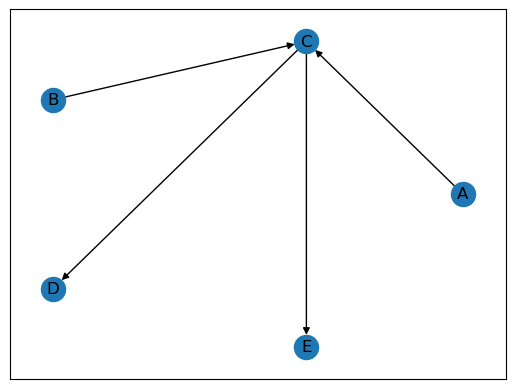

In [38]:
graph_labeled = nx.relabel_nodes(graph, id_to_name)
pos = nx.circular_layout(graph_labeled)
nx.draw_networkx(graph_labeled, pos, with_labels=True)

plt.show()

**Question:** What is the size of the Markov Equivalence class of the above graph?

**Answer:** The size of the Markov Equivalence class is 1. This is the only DAG that encodes the conditional independence assumptions of this graph is this graph.

### Test on real data
We will now test our PC algorithm on a real dataset. Here we provide you with a code which uploads the dataset from the paper "What Do College Ranking Data Tell Us About Student Retention?" by Drudzel and Glymour. This dataset contains the following features:
  - `spending_per_stdt` - total education and general expenses per student,
  - `grad_rate` - average percentage of graduation,
  - `stdt_clss_stndng` - class standing of the incoming freshmen,
  - `rjct_rate` - rejection rate,
  - `tst_scores` - average test scores of incoming students,
  - `stdt_accept_rate` - pecentage of admitted students who accept university's offer,
  - `stdt_tchr_ratio` - student teacher ratio,
  - `fac_salary` - average faculty salary.

For more details, you can look into the article. 

In [39]:
url = "https://www.ccd.pitt.edu//wp-content/uploads/files/Retention.txt"
data = pd.read_csv(url, sep='\s+')
data_np = data.to_numpy()

In [40]:
alpha = 0.05
id_to_name = {key: name for key, name in enumerate(data.columns)}
# Replace "..." with your code
# Use the PC algorithm implemented before to find a causal graph that represents the given data
graph = PC(data_np,alpha)

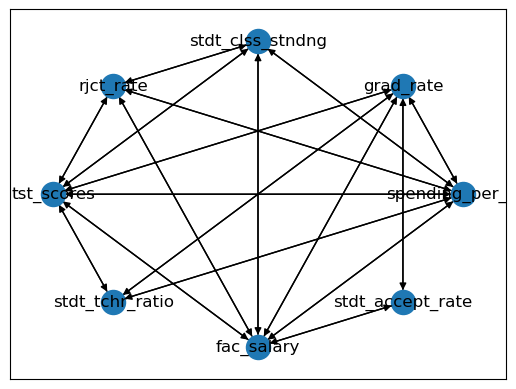

In [41]:
graph_labeled = nx.relabel_nodes(graph, id_to_name)
pos = nx.circular_layout(graph_labeled)
nx.draw_networkx(graph_labeled, pos, with_labels=True)

plt.show()

**Question:** Why are there some (one or more) bidirected edges in the graph? What does it mean?

**Answer:** In a DAG there can be in theory no double oriented of rather unoriented edges. We can see this in practice because the data is correlated in a way that creates ambiguity, so each combination of the arrows is possible, with the provided data. It would require additional data to see which of the ways is correct. 